In [2]:
import os
import yaml
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split

from model import CINN
from plot_utils import (
    load_model_and_data,
    sample_posteriors,
    compute_map_estimates,
    build_priors_from_training,
)



In [7]:
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri']


TARGET_UNITS = [
    r'$\mathrm{Gyr}$',                # last_T_coll
    r'$\mathrm{km/s}$',               # last_V_coll
    r'$10^{14}\,M_\odot$',            # last_M_Crit500_coll
    r'$10^{14}\,M_\odot$',            # last_Subcluster_mass
    r'' ,                             # last_Mass_ratio (unitless)
    r'$\mathrm{kpc}$',                # last_d_peri        
]


In [8]:
def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    params_path: str = "params.yaml",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    Under the new embeddings→CINN→features pipeline, plot |MAP − truth| vs. posterior σ
    for each target dimension, including units.
    
    Assumes load_model_and_data returns:
      • model       : trained CINN
      • X_full      : numpy array of shape (N_proj, D_emb)  [embeddings]
      • Y_full      : numpy array of shape (N_proj, D_tar_scaled)
      • tar_sc      : StandardScaler used to scale Y
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ─── 1) Load (CINN, embeddings, scaled‐targets Y, scaler) ───────────────────────────
    model, X_full, Y_full, tar_sc = load_model_and_data(
        model_checkpoint=model_checkpoint,
        params_path=params_path,
        processed_dir=processed_dir,
        device=device
    )
    # Here:
    #   X_full shape = (N_proj, D_emb)
    #   Y_full shape = (N_proj, D_tar_scaled)
    #   tar_sc is the StandardScaler fitted on the original Y

    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS), "TARGET_COLS length must match number of target dims"

    # ─── 2) Build test set by splitting 10% of the projections ────────────────────────────
    N = len(X_full)
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)

    X_test = X_full[idx_test]                     # (N_test, D_emb)
    Y_test = Y_full[idx_test]                     # (N_test, D_tar_scaled)
    truth_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar_phys)

    # ─── 3) Draw posterior samples (in physical units) for each test projection ───────────
    post_phys = sample_posteriors(
        model,
        X_test,
        tar_sc,
        n_samples=n_posterior_samples,
        device=device
    )
    # post_phys shape = (N_test, n_posterior_samples, D_tar_phys)

    # ─── 4) Compute MAP estimates and posterior standard deviations ───────────────────────
    map_phys = compute_map_estimates(post_phys)      # (N_test, D_tar_phys)
    std_phys = post_phys.std(axis=1)                 # (N_test, D_tar_phys)

    # ─── 5) Plot |MAP – truth| vs σ for each target dim ─────────────────────────────────
    fig, axes = plt.subplots(
        1,
        D_tar,
        figsize=(4 * D_tar, 5),
        squeeze=False
    )

    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        # Filter to remove extreme outliers in σ
        p5, p95 = np.percentile(std_d, [5, 95])
        mask = (std_d >= p5) & (std_d <= p95)
        err_in, std_in = err_d[mask], std_d[mask]

        # Scatter |MAP−truth| vs. σ, include unit on both axes
        ax.scatter(err_in, std_in, s=50, alpha=1.0)

        # Reference lines: y = x and y = x * sqrt(pi/2)
        lims = np.linspace(err_in.min(), err_in.max(), 200)
        ax.plot(lims, lims,                    '--', color='gray', linewidth=2)
        ax.plot(lims, lims * np.sqrt(np.pi / 2), '--', color='gray', linewidth=2)

        # Bin‐wise statistics (68th and 95th percentiles)
        bin_edges   = np.linspace(std_in.min(), std_in.max(), num_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        pct68       = np.empty(num_bins)
        pct95       = np.empty(num_bins)

        for i in range(num_bins):
            sel = (std_in >= bin_edges[i]) & (std_in < bin_edges[i + 1])
            if sel.any():
                pct68[i] = np.percentile(err_in[sel], 68)
                pct95[i] = np.percentile(err_in[sel], 95)
            else:
                pct68[i] = np.nan
                pct95[i] = np.nan

        ax.plot(pct68, bin_centers, '-', color='blue',  linewidth=2, label='68th pct error')
        ax.plot(pct95, bin_centers, '-', color='black', linewidth=2, label='95th pct error')

        ax.axvline(0, color='peachpuff', linewidth=2)

        # Symlog on both axes with independent linthresh
        ax.set_xscale("symlog", linthresh=linthresh_x)
        ax.set_yscale("symlog", linthresh=linthresh_y)

        ax.set_title(TARGET_COLS[d], fontsize=16)
        # Include unit in x‐label and y‐label via a simple f‐string (LaTeX portion + unit in parens)
        ax.set_xlabel(
            f"$|\\mathrm{{MAP}}-\\mathrm{{truth}}|$ ({TARGET_UNITS[d]})",
            fontsize=14
        )
        if d == 0:
            ax.set_ylabel(
                f"$\\sigma_\mathrm{{post}}$ ({TARGET_UNITS[d]})",
                fontsize=14
            )
        ax.legend(fontsize=10, loc='upper left')
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("3.uncertainities.png", dpi=300, bbox_inches='tight')
    #plt.savefig("3.uncertainities.pdf", dpi=300, bbox_inches='tight')
    plt.show()

<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_50572/2153110654.py:118: SyntaxWarning: invalid escape sequence '\m'
  f"$\\sigma_\mathrm{{post}}$ ({TARGET_UNITS[d]})",


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/vera/u/jshera/CINN_spline/representation_space/plot_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)
num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_

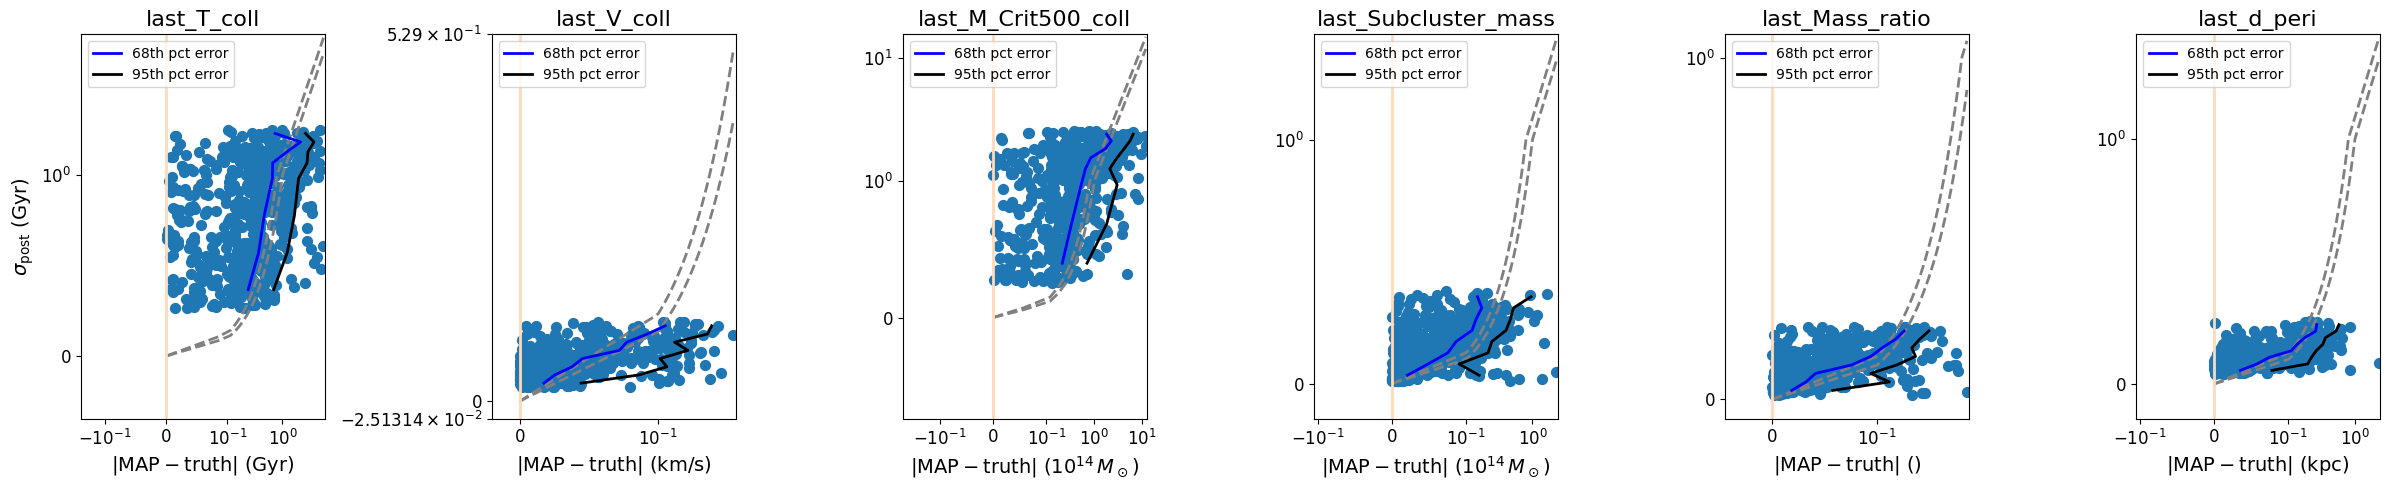

In [9]:
if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="experts/",
        processed_dir="processed_data",
        params_path="params.yaml",
        n_posterior_samples=600,
        num_bins=8,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )